# BINF GU 4002: Machine Learning for Healthcare, Spring 2025
# Assignment \#2: Regularization and Model Selection
## DUE: 11:59 PM, Tuesday, March 11, 2025

This assignment explores regularization and model selection. We will use ideas explored in class and build intuition around how to select appropriate modelling techniques for the specific data and task you have. As an illustrative example, you will be using embeddings generated from a large-scale protein language model to predict the structural effects of a mutation in the protein sequence.

**<font color="red">Instructions: Please run the notebook using Google Colab to prevent any dependency / package issues. Make sure that your written answers are formatted using </font>$\LaTeX$<font color="red"> in `markdown` cells. When submitting, please name your files `{UNI}_binf4002_mlhc_assignment_2.{filetype}` and submit a `.ipynb` version of your Jupyter notebook. Additionally, we will render the jupyter notebook using nbviewer (https://nbviewer.org/). When you are submitting your final version, upload your homework to a public github repository and paste the github link to nbviewer and obtain the final rendered link </font>**

Link to github repository: [https://github.com/DILIU899/BINF4002_MLHC.git](https://github.com/DILIU899/BINF4002_MLHC.git)

Link to nbviewer render: [https://nbviewer.org/github/DILIU899/BINF4002_MLHC/blob/main/HW2/dl3738_binf4002_mlhc_assignment_2.ipynb](https://nbviewer.org/github/DILIU899/BINF4002_MLHC/blob/main/HW2/dl3738_binf4002_mlhc_assignment_2.ipynb)

#### The Problem and Data

We will be using data from the [Envision](https://pmc.ncbi.nlm.nih.gov/articles/pmid/29226803/) paper (Gray et al.2018). The goal is to perform variant effect prediction, where variants of β-Lactamase are created by through single-residue mutations (one amino-acid is replaced by another amino-acid in the protein sequence). The data is generated using a method called deep mutational scan.

From Gray et al. 2018:

> In a deep mutational scan, selection for protein function among a library of nearly all possible single amino acid variants of a protein is coupled to high-throughput DNA sequencing (Fowler and Fields, 2014; Fowler et al., 2014). Sequencing reveals how each variant’s frequency changes during selection, yielding quantitative scores that describe the functional effect of each variant in the library. A large-scale mutagenesis dataset contains deep and unbiased information, capturing the effects of most variants at every position in a single protein. We hypothesize that large-scale mutagenesis datasets contain informative and generalizable patterns that can be used to predict variant effects in disparate proteins.

The prediction target is a quantitative metric known as variant effect score, which depends on the protein of interest. For example, this score may capture the severity of functional disruption.

The embeddings are generated from [ESM](https://www.nature.com/articles/s41588-023-01465-0), a large-scale language (foundation) model for protein sequences developed by Meta AI. The repository can be found here: https://github.com/facebookresearch/esm/tree/main  

In [ ]:
# STARTER CODE
## get data
# !mkdir data
# !cd data
# !curl -O https://dl.fbaipublicfiles.com/fair-esm/examples/P62593_reprs.tar.gz
# !tar -xzf P62593_reprs.tar.gz
# !rm P62593_reprs.tar.gz
# !curl -O https://dl.fbaipublicfiles.com/fair-esm/examples/P62593.fasta

In [1]:
FASTA_PATH = "./data/P62593.fasta" # Path to P62593.fasta
EMB_PATH = "./data/P62593_reprs" # Path to directory of embeddings for P62593.fasta
EMB_LAYER = 34

In [2]:
import random
from collections import Counter
from tqdm import tqdm

import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import scipy
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.decomposition import PCA

import esm

ys = []
Xs = []

for header, _seq in esm.data.read_fasta(FASTA_PATH):
    scaled_effect = header.split('|')[-1]
    ys.append(float(scaled_effect))
    fn = f'{EMB_PATH}/{header}.pt'
    embs = torch.load(fn)
    Xs.append(embs['mean_representations'][EMB_LAYER])

Xs = torch.stack(Xs, dim=0).numpy()

train_size = 0.8
Xs_train, Xs_test, ys_train, ys_test = train_test_split(Xs, ys, train_size=train_size, random_state=42)

print(Xs.shape)

/var/folders/pf/0vf6rdxj125byrc2yq3mf16m0000gp/T/ipykernel_39893/1060336957.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  embs = torch.load(fn)


(5397, 1280)


#### Data exploration

Note that the embeddings are high-dimensional. To qualitatively analyse if there are patterns (ex. naturally-forming clusters) in the data, we can visualize the data using dimensionality reduction. The color indicates the level of functional distruption in the protein, and each point represents a different amino-acid sequence containing a specific mutation.

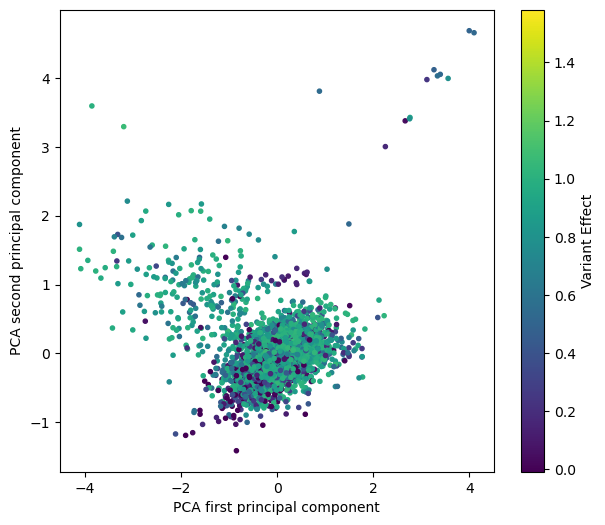

In [3]:
num_pca_components = 60
pca = PCA(num_pca_components)
Xs_train_pca = pca.fit_transform(Xs_train)

fig_dims = (7, 6)
fig, ax = plt.subplots(figsize=fig_dims)
sc = ax.scatter(Xs_train_pca[:,0], Xs_train_pca[:,1], c=ys_train, marker='.')
ax.set_xlabel('PCA first principal component')
ax.set_ylabel('PCA second principal component')
plt.colorbar(sc, label='Variant Effect')
plt.show()

## [30 Points] Question 1: Bias Variance Tradeoff

Modeling data in healthcare is often in a data-constrained setting, where we may be restricted to high dimensional data with limited samples due to costs of experimentation and data acquisition. However, a key desiderata for our models is the ability to generalize to unseen samples.

How do we know if we have enough data for a given modelling task to achieve generalization? How do we choose the right modeling strategy? We will explore these questions using a phenomenon in machine learning known as the bias-variance tradeoff.

Consider a dataset $$D = \{(x_1, y_1), (x_2, y_2), ..., (x_n, y_n) \}$$

and suppose that the relationship between $x \in \mathbb{R}^1$ and $y \in \mathbb{R}^1$ values are specified by an unknown true underlying function as $y = f(x) + \epsilon$ where $\epsilon \sim N(0, \sigma^2)$.

Now, suppose we have trained an approximation of the underlying true function using the training dataset with $\hat{y} = \hat{f}(x)$, where $\hat{y}$ corresponds to the prediction of $y$

#### [15 Points] 1.1: Prove the bias-variance decomposition of mean squared error
$$\mathbb{E}_{D} \left[(y - \hat{f}(x) )^2\right] = \underbrace{\left(\mathbb{E}\left[\hat{f}(x) \right] - f(x) \right)^2}_{Bias^2} + \underbrace{\mathbb{E}_{D}\left[\left(\hat{f}(x) - \mathbb{E}\left[\hat{f}(x)\right] \right)^2 \right]}_{Variance} + \sigma^2$$

<font color="red">Answer 1.1</font>

\begin{aligned}
\mathbb{E}_{D} \left[(y - \hat{f}(x) )^2\right] &= \mathbb{E}_{D} \left[\left(f(x) - \hat{f}(x) + \epsilon \right)^2\right] \\
&= \mathbb{E}_{D} \left[\left(f(x) - \hat{f}(x) \right)^2 + 2\epsilon \left(f(x) - \hat{f}(x) \right) + \epsilon^2 \right] \\
&= \mathbb{E}_{D} \left[\left(f(x) - \hat{f}(x) \right)^2\right] + 2 \mathbb{E}_{D} \left[ \epsilon \left( f(x) - \hat{f}(x)\right) \right] + \mathbb{E}_{D}[\epsilon^2] \\
\end{aligned}

Here, we have

\begin{aligned}
\mathbb{E}_{D} \left[\left(f(x)  - \hat{f}(x) \right)^2\right] &= \mathbb{E}_{D} \left[\left(f(x) - \mathbb{E}\left[\hat{f}(x) \right] + \mathbb{E}\left[\hat{f}(x) \right] - \hat{f}(x) \right)^2\right] \\
&= \mathbb{E}_{D} \left[\left(f(x) - \mathbb{E}\left[\hat{f}(x) \right]\right)^2 \right] + \mathbb{E}_{D} \left[ \left(\mathbb{E}\left[\hat{f}(x) \right] - \hat{f}(x) \right)^2\right] \\
&+ 2 \mathbb{E}_{D} \left[ \left(f(x) - \mathbb{E}\left[\hat{f}(x) \right]\right) \left(\mathbb{E}\left[\hat{f}(x) \right] - \hat{f}(x)\right) \right]
\end{aligned}

- For $\mathbb{E}_{D} \left[\left(f(x) - \mathbb{E}\left[\hat{f}(x) \right]\right)^2 \right]$, since we don't have randomness for both $f(x)$ and $\mathbb{E}\left[\hat{f}(x) \right]$, we have $\mathbb{E}_{D} \left[\left(f(x) - \mathbb{E}\left[\hat{f}(x) \right]\right)^2 \right] = \left(\mathbb{E}\left[\hat{f}(x) \right] - f(x) \right)^2$. 
- For $2 \mathbb{E}_{D} \left[ \left(f(x) - \mathbb{E}\left[\hat{f}(x) \right]\right) \left(\mathbb{E}\left[\hat{f}(x) \right] - \hat{f}(x)\right) \right]$, since we only have $\hat{f}(x)$ to have randomness, we have $2 \mathbb{E}_{D} \left[ \left(f(x) - \mathbb{E}\left[\hat{f}(x) \right]\right) \left(\mathbb{E}\left[\hat{f}(x) \right] - \hat{f}(x)\right) \right] = 2 \left(f(x) - \mathbb{E}\left[\hat{f}(x) \right]\right) \left( \mathbb{E}\left[\hat{f}(x) \right] - \mathbb{E}_{D} \left[ \hat{f}(x) \right] \right) = 0$

So we have 

$$
\mathbb{E}_{D} \left[\left(f(x)  - \hat{f}(x) \right)^2\right] = \left(\mathbb{E}\left[\hat{f}(x) \right] - f(x) \right)^2 + \mathbb{E}_{D}\left[\left(\hat{f}(x) - \mathbb{E}\left[\hat{f}(x)\right] \right)^2 \right]
$$

Then, for $\mathbb{E}_{D} \left[ \epsilon \left( f(x) - \hat{f}(x)\right) \right]$, since the noise $\epsilon$ and $\hat{f}(x)$ are independent, we can decompose the expectation as  $\mathbb{E}_{D} \left[ \epsilon \right]  \mathbb{E}_{D} \left[ \left( f(x) - \hat{f}(x)\right) \right]$. We have $\mathbb{E}_{D} \left[ \epsilon \right]=0$, so we have $\mathbb{E}_{D} \left[ \epsilon \left( f(x) - \hat{f}(x)\right) \right] = 0$

Last, for $\mathbb{E}_{D}[\epsilon^2]$, since we have $Var(\epsilon) = \mathbb{E}_{D}[\epsilon^2] - \mathbb{E}_{D}\left[\epsilon\right]^2$, $\mathbb{E}_{D}[\epsilon^2] = Var(\epsilon) + \mathbb{E}_{D}[\epsilon]^2 = \sigma^2 + 0 = \sigma^2$

So finally, we have the result as

\begin{aligned}
\mathbb{E}_{D} \left[(y - \hat{f}(x) )^2\right] &=  \mathbb{E}_{D} \left[\left(f(x) - \hat{f}(x) \right)^2\right] + 2 \mathbb{E}_{D} \left[ \epsilon \left( f(x) - \hat{f}(x)\right) \right] + \mathbb{E}_{D}[\epsilon^2] \\
&= \left(\mathbb{E}\left[\hat{f}(x) \right] - f(x) \right)^2 + \mathbb{E}_{D}\left[\left(\hat{f}(x) - \mathbb{E}\left[\hat{f}(x)\right] \right)^2 \right] + 0 + \sigma^2 \\
\mathbb{E}_{D} \left[(y - \hat{f}(x) )^2\right] &= \left(\mathbb{E}\left[\hat{f}(x) \right] - f(x) \right)^2 + \mathbb{E}_{D}\left[\left(\hat{f}(x) - \mathbb{E}\left[\hat{f}(x)\right] \right)^2 \right] + \sigma^2
\end{aligned}

#### [5 Points] 1.2: What does it mean for the prediction model $\hat{f}(x)$ to have high bias? What are potential causes of high bias?

<font color="red">Answer 1.2</font>

High bias means the model is systematically having the predicted value $\hat{f}(x)$ different from the true value. This can be caused by 
- the model is too simple and underfitting the data 
- the feature is not predictive for the prediction task
- the training data has intrinsic bias

#### [5 Points] 1.3: What does it mean for the model to have high variance? What are potential causes of high variance?

<font color="red">Answer 1.3</font>

High variance means the model is too sensitive to the change of the input feature (even sensitive to the noise or slight fluctation in the training data). This can be caused by 

- the model is too complex and overfitting the data
- the training data size is too small

#### [5 Points] 1.4 Can bias and variance decrease at the same time?

<font color="red">Answer 1.4</font>

Generally speaking, bias and variance cannot decrease at the same time. We have the bias-variance trade off, that is, with the model complexity increasing, the bias is going down and the variance is going up. We can get the best model complexity based on this trade-off.

Since here we do not specify under which scenario, there can be some cases, like during the training stage, the bias and variance can both decrease as we are generally having a better model given the hypothesis space.

# [30 Points] Question 2: Regularization

A model with high bias is also called "underfitting", while a model with high variance is also called "overfitting". One idea from the bias-variance tradeoff is that purposefully introducing bias may be an effective strategy in mitigating overfitting and reducing variance.

We will now explore regularization, a common strategy used to introduce bias in the model to improve generalization.

Consider a dataset $$D = \{(\textbf{x}_1, y_1), (\textbf{x}_2, y_2), ..., (\textbf{x}_n, y_n) \}$$

where now each sample contains a vector of $d$ features $\textbf{x}_i \in \mathbb{R}^{d \times 1}$

Suppose we specifiy our model to be a linear regression model. That is, we consider a model with a vector of parameters $\beta \in \mathbb{R}^{d \times 1}$ such that $y_i = \textbf{x}_i^T \beta + \epsilon $

Note that we can equivalently write the set of $n$ equations stacked together using a matrix $\textbf{X} \in \mathbb{R}^{n \times d}$ and $\textbf{y} \in \mathbb{R}^{n \times 1}$ as follows:

$$\textbf{y} = \textbf{X} \beta + \epsilon \text{ , } \quad \epsilon \sim N(0, \sigma^2 I)$$

#### [10 Points] Question 2.1: Derive the optimal solution to the L2-regularized Squared Error Loss (also known as ridge regression) given by

$$(\textbf{X}\beta - \textbf{y})^T(\textbf{X}\beta - \textbf{y}) + \lambda \beta^T\beta $$

<font color="red">Answer 2.1</font>

\begin{aligned}
\frac{\partial Loss}{\partial \beta} &= \frac{\partial}{\partial (\textbf{X}\beta - \textbf{y})}(\textbf{X}\beta - \textbf{y})^T(\textbf{X}\beta - \textbf{y}) \frac{\partial (\textbf{X}\beta - \textbf{y})}{\partial \beta} + \lambda \frac{\partial \beta^T\beta}{\partial \beta} \\
&= 2 (\textbf{X}\beta - \textbf{y})^T X + 2 \lambda \beta^T \\
&= 2 \beta^T(X^TX + \lambda I) - 2y^TX = 0
\end{aligned}

So we have 

\begin{aligned}
(X^TX + \lambda I)\beta &= X^T y \\
\hat{\beta} &= (X^TX + \lambda I)^{-1} X^Ty
\end{aligned}


#### [15 Points] Question 2.2: Build a Ridge Regression with the skeleton code below (Fill in TODOs).

In [4]:
class RidgeRegression:
    def __init__(self, lambda_reg=1.0):
        self.lambda_reg = lambda_reg  # Regularization parameter
        self.beta = None  # Coefficients

    def fit(self, X, y):
        """ Compute the closed-form solution for Ridge Regression. """
        n, d = X.shape
        I = np.eye(d)  # Identity matrix
        XTX = X.T @ X  # Compute X^T X
        XTy = X.T @ y  # Compute X^T y

        # Closed-form solution
        self.beta = np.linalg.solve(
            XTX + self.lambda_reg * I,
            XTy
        )

    def predict(self, X):
        """ Predict using the learned weights. """
        return X @ self.beta

    def mse(self, y_true, y_pred):
        """ Compute Mean Squared Error (MSE). """
        return np.mean((y_true - y_pred) ** 2)

In [5]:
# Define a range of lambda values
lambdas = np.logspace(-3, 3, 30)  # From 0.001 to 1000
mse_values = []
variance_values = []

# Compute bias and variance for each lambda
for lambda_reg in lambdas:
    model = RidgeRegression(lambda_reg)
    model.fit(Xs_train, ys_train)

    predictions = model.predict(Xs_test)
    mse = np.mean((ys_test - predictions) ** 2)
    variance = np.var(predictions)

    mse_values.append(mse)
    variance_values.append(variance)

#### [5 Points] Question 2.3: What do you notice in the relationship between MSE and variance as we increase the lambda parameter?

<font color="red">Answer 2.3</font>

We can observe that as we increase the lambda, the variance is decreasing and the MSE is decreasing in the very first place and increasing when the lambda is too big. When we increase the regularization parameter $\lambda$, we are going to have simpler model (the model complexity is decreasing), so it's in line with our expectation that the variance is decreasing as we are having simpler model. As for MSE, when we are having too simple model (the $\lambda$ is too big), though we have smaller variance, the bias is big so the MSE is increasing. When we are having too complex model (the $\lambda$ is too small), the bias is small but the variance is big, so the MSE is also big.

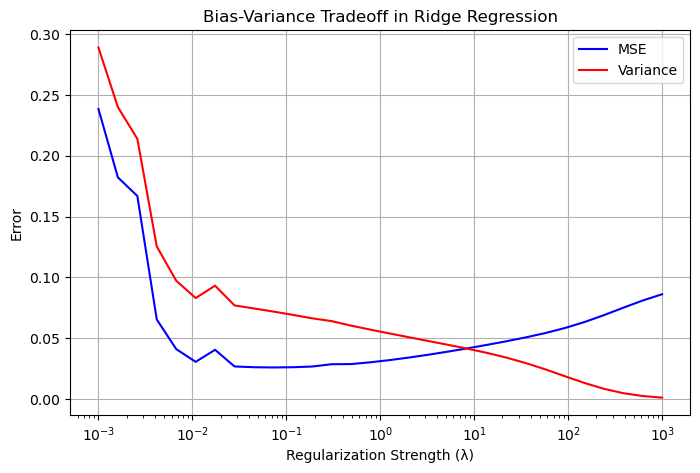

In [6]:
# Plotting Code for question 2.3

plt.figure(figsize=(8, 5))
plt.plot(lambdas, mse_values, label="MSE", color='blue')
plt.plot(lambdas, variance_values, label="Variance", color='red')
plt.xscale('log')  # Log scale for better visualization
plt.xlabel("Regularization Strength (λ)")
plt.ylabel("Error")
plt.title("Bias-Variance Tradeoff in Ridge Regression")
plt.legend()
plt.grid()
plt.show()

In [25]:
np.min(mse_values)

0.02595708826568366

In [26]:
lambdas[np.argmin(mse_values)]

0.0727895384398315

# [20 Points] Question 3: Bayesian Variable Selection

Follwing the intuition we have built around regularization, we will now explore a more complex Bayesian model for the protein variant effect prediction task. We assume the same linear model with the same dimensionality as before

$$\textbf{y} = \textbf{X} \beta + \epsilon \text{ , } \quad \epsilon \sim N(0, \sigma^2 I)$$

However, now we will introduce a prior on the model parameters $\beta$. For each $\beta_j$ where $j=1, ..., d$, the prior takes the following form

$$ \beta_j | \gamma_j \sim (1 - \gamma_j)\cdot 0 + \gamma_j N(0, \sigma_\beta^2) \text{ , } \quad \gamma_j \sim \text{Bernoulli}(p)$$

Equivalently, we can rewrite the resulting model in a slightly more compact form where $\circ$ indicates a element-wise (hadamard) product between two vectors.

$$ \beta \sim N(0, \sigma_\beta^2) $$
$$ \textbf{y}_i | \textbf{x}_i, \beta, \gamma \sim N((\gamma \circ \beta)^T \textbf{x}_i, \sigma^2)$$


#### [5 Points] 3.1: What is the role of the $\gamma$ parameter in determining $\beta$ in the prior? What happens when $\gamma = 1$ and $\gamma = 0$?

<font color="red">Answer 3.1</font>

The $\gamma$ parameter is used to "turn on" or "turn off" using the corresponding feature $j$. When $\gamma=1$, the prior of $\beta$ is $N(0, \sigma_{\beta}^2)$, that is similar to the ridge regression. When $\gamma = 0$, the prior of $\beta$ is $0$, then the posterior distribution of $\beta$ will also be $0$, that is, we are setting this parameter $\beta_j$ to $0$ and we are excluding the feature $j$ in the design matrix. With the $\gamma$, we can enable some sparsity of the parameter.

#### [10 Points] 3.2: We would like to fit the parameters $\gamma, \beta$ using MAP estimation. Write the posterior objective $p(\gamma, \beta | \textbf{X}, \textbf{y})$ in terms of the priors and likelihoods. (We will assume $\sigma^2$ is fixed for purposes of this problem)

Hints: Recall the posterior probability we wish to maximize given data is $p(\theta | \text{X}, \text{y}) \propto p(\theta) \prod_i^n p(y_i |x_i, \theta) $. What are the distributional families of the priors and likelihoods?

<font color="red">Answer 3.2</font>

Here we denote the PMF of $\delta_0(\beta_j)$ as

\begin{aligned}
\delta_0(\beta_0) = \begin{cases}
1 &, \beta_j =0 \\
0 &, other
\end{cases}
\end{aligned}

Then we have our posterior distribution as 

\begin{aligned}
p(\gamma, \beta| \textbf{X}, \textbf{y}) &\propto \underbrace{p(\textbf{y} | \textbf{X}, \beta, \gamma)}_{\text{liklihood}} \underbrace{p(\beta | \gamma)}_{\text{Prior} \beta|\gamma} \underbrace{p(\gamma)}_{\text{Prior} \gamma} \\
&= \prod_{i=1}^{n} N(y_i | (\gamma \circ \beta)^T \textbf{x}_i, \sigma^2) \prod_{j=1}^{d} N(\beta_j | 0, \sigma_\beta^2)^{\gamma_j} \delta_0(\beta_j)^{1-\gamma_j} \prod_{j=1}^{d} p^{\gamma_j} (1-p)^{1-\gamma_j} \\
&= \prod_{i=1}^{n} N( y_i | \sum_{j=1}^d \gamma_j \beta_j \textbf{x}_{ij}, \sigma^2) \prod_{j=1}^{d} N(\beta_j | 0, \sigma_\beta^2)^{\gamma_j} \delta_0(\beta_j)^{1-\gamma_j} \prod_{j=1}^{d} p^{\gamma_j} (1-p)^{1-\gamma_j}
\end{aligned}

This is hard to give an analytic solution. When we're going to do simulation, we first sample one $\gamma$ from the bernoulli distribution, then we get the conditional distribution of $\beta$ and we sample one $\beta$ from the distribution. We finally get the distribution for generating label $y$.

#### [5 Points] 3.3: Run the code below to obtain the MAP estimate of the optimal parameters of $\gamma$. Interpret the plot. What does the posterior $p(\gamma_j = 1 | \textbf{X}, \textbf{y})$ being high or low indicate for a given $j \in \{1, ..., d\}$?

In [8]:
import pymc as pm

num_features = Xs_train.shape[1]

# Bayesian model with spike-and-slab prior (note this takes around 5 minutes)
# Note that in 3.2, the expression cannot be optimized analytically with a closed form solution.
# The following code uses an iterative gradient decsent optimization procedure to find a local maximum

with pm.Model() as model:
    logit_gamma = pm.Normal("logit_gamma", mu=0, sigma=1, shape=num_features)
    gamma = pm.Deterministic("gamma", pm.math.sigmoid(logit_gamma))  # Continuous approximation of bernoulli to speed up gradient-based optimization

    beta = pm.Normal("beta", mu=0, sigma=1, shape=num_features) * gamma
    sigma = pm.HalfNormal("sigma", sigma=1) # This is a normal distribution but only takes positive values (positive half of a normal distribution)

    mu = pm.math.dot(Xs_train, beta)
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=ys_train)

    map_estimate = pm.find_MAP()

/Users/dl3738/miniforge3/envs/dl/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" 
for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

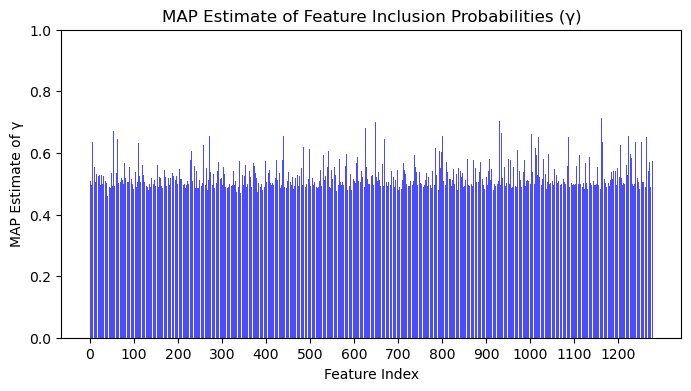

In [10]:
gamma_map = map_estimate["gamma"]

# Plot the MAP estimate of gamma
plt.figure(figsize=(8, 4))
plt.bar(np.arange(len(gamma_map)), gamma_map, color="blue", alpha=0.7)
plt.xlabel("Feature Index")
plt.ylabel("MAP Estimate of γ")
plt.title("MAP Estimate of Feature Inclusion Probabilities (γ)")
plt.xticks(np.arange(0, len(gamma_map), 100))
plt.ylim(0, 1)  # Since gamma is in (0,1)
plt.show()

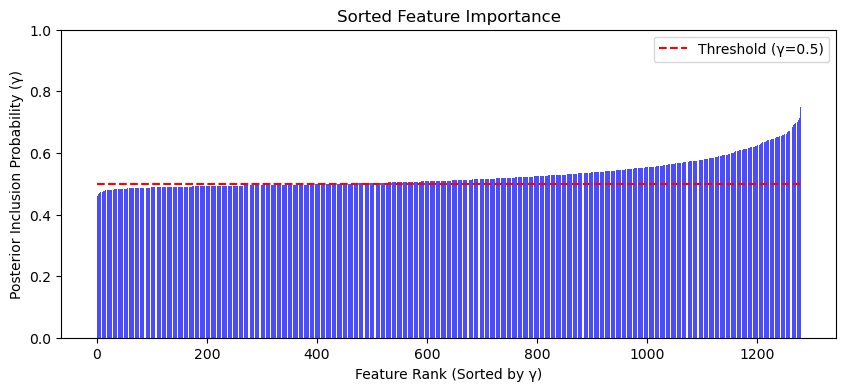

In [16]:
plt.figure(figsize=(10, 4))
sorted_gamma = np.sort(gamma_map)
sorted_indices = np.argsort(gamma_map)

plt.bar(np.arange(len(gamma_map)), sorted_gamma, color="blue", alpha=0.7)
plt.hlines(0.5, 0, len(gamma_map), color="red", linestyles="--", label='Threshold (γ=0.5)')

plt.xlabel("Feature Rank (Sorted by γ)")
plt.ylabel("Posterior Inclusion Probability (γ)")
plt.title("Sorted Feature Importance")
plt.ylim(0, 1)
plt.legend()
plt.show()

<font color="red">Answer 3.3</font>

Here, when the posterior probability $p(\gamma_j = 1 | \textbf{X}, \textbf{y})$ is low, it means the corresponding parameter is very likely to be set as $0$, which further means the corresponding feature $j$ is not important (actually acting as noise) during the prediction. When the probability is high, it means the model needs the corresponding feature $j$ to do the prediction and we need to learn the corresponding parameter $\beta_j$.

For the plot, we can observe most of the posterior probability to be around $0.5$, which means the importance of the corresponding feature is kind of neutral (with / without the feature will not cause big difference). This may be caused by the feature redundancy with others (collinearity), little signal from the training data, little correlation between the corresponding feature and the label. Some of the probability is higher, corresponding to important feature to the prediction. From the plot, it seems like most of the features from ESM2 are not very predictive for the task. 

# [10 Points] Question 4: Model Selection & Cross Validation

Using the intuition we have built around regularization, we will now explore practical strategies for selecting the best parameters for a model. We will use the following function to perform cross validation

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

#### [10 Points] 3.1: Define a range of parameters and number of cross validation folds. Report the best parameter and mean squared error obtained on the held-out testing data

In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

ridge_model = Ridge()

# Define hyperparameter grid for Ridge Regression (This is only graded on completion and not on model performance)
param_grid = {'alpha': np.arange(0, 2, 0.1)} #TODO: Fill in

# Perform GridSearchCV with 3-fold cross-validation
grid_search = GridSearchCV(estimator=ridge_model, param_grid=param_grid, scoring="neg_mean_squared_error", cv=3, n_jobs=-1, verbose=2)
grid_search.fit(Xs_train, ys_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END ..........................................alpha=0.1; total time=   0.2s
[CV] END ..........................................alpha=0.1; total time=   0.2s
[CV] END ..........................................alpha=0.0; total time=   0.2s
[CV] END ..........................................alpha=0.1; total time=   0.2s
[CV] END ..........................................alpha=0.0; total time=   0.2s
[CV] END ..........................................alpha=0.2; total time=   0.2s
[CV] END ..........................................alpha=0.2; total time=   0.2s
[CV] END ..........................................alpha=0.0; total time=   0.2s


/Users/dl3738/miniforge3/envs/dl/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.44834e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/dl3738/miniforge3/envs/dl/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.3339e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/dl3738/miniforge3/envs/dl/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=3.72809e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


[CV] END ..........................................alpha=0.2; total time=   0.2s
[CV] END ..........................alpha=0.30000000000000004; total time=   0.2s
[CV] END ..........................alpha=0.30000000000000004; total time=   0.2s
[CV] END ..........................alpha=0.30000000000000004; total time=   0.2s
[CV] END ..........................................alpha=0.4; total time=   0.2s
[CV] END ..........................................alpha=0.5; total time=   0.2s
[CV] END ..........................................alpha=0.4; total time=   0.3s
[CV] END ..........................................alpha=0.4; total time=   0.3s
[CV] END ..........................................alpha=0.5; total time=   0.2s
[CV] END ..........................................alpha=0.5; total time=   0.2s
[CV] END ...........................alpha=0.6000000000000001; total time=   0.2s
[CV] END ...........................alpha=0.7000000000000001; total time=   0.2s
[CV] END ...................

GridSearchCV(cv=3, estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9])},
             scoring='neg_mean_squared_error', verbose=2)

In [20]:
grid_search.best_params_["alpha"]

0.1

In [22]:
pred = grid_search.predict(Xs_test)
mse = np.mean((ys_test - pred) ** 2)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 0.025795118534291003
